# text exploration

- statistics
    - length, etc.
- cleaning
- reduce data
    - consider taking only x first sentences
- pca
- stemming
- tokenizing
- implement tf-idf 

In [31]:
import re
import random
import string

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords as sw
from nltk.stem import PorterStemmer

from utils.read_data import read_articles_file

In [32]:
stemmer = PorterStemmer()
stopwords = set(sw.words("english"))

## Read data

In [33]:
N = 1000

article_texts_path = "/work3/s204163/wiki/article_texts"
article_ids_path = "/work3/s204163/wiki/article_ids"

all_articles = read_articles_file(article_texts_path, return_titles = False)

### Text processing

In [34]:
# Translator for removing punctuation, including non unicode U+2013 character "–", very common
punctuation_translator = str.maketrans(string.punctuation + '\u2013', " " * (len(string.punctuation) + 1))

def remove_numbers(text:str) -> str:
    """ Match all digits in the string and replace them with an empty string """
    new_text = re.sub(r'[0-9]', ' ', text)
    return new_text


def remove_blank_space(text: str) -> str:
    """ Stolen from: https://stackoverflow.com/a/1546244"""
    # return re.sub(' +', ' ', text)        # Doesnt really work
    # return re.sub(' {2,}', ' ', text)     # Doesnt really work
    return " ".join(text.split()) # TODO: Slooowwwwww


def clean(text: str) -> str:
    """ Strip the text of punctutaion, numbers, excessive spaces, etc. """
    text = remove_numbers(text)                                         # remove numbers
    text = text.translate(punctuation_translator)                       # remove punctuation: !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    text = text.lower()                                                 # convert to lower case
    text = remove_blank_space(text)                                     # remove double+ spacing
    text = text.strip()                                                 # remove newline characters and spaces
    return text

In [35]:
def preprocess(text: str) -> str:
    """
    Do preprocessing which includes:
        - cleaning text
        - removing stop words
        - stemming words
    """
    text = clean(text)
    
    # Do stop word removal and stemming in one pass, looks messy saves some time
    words = text.split()
    return " ".join([stemmer.stem(word) for word in words if not word in stopwords])


def random_articles(articles: set, N : int, seed: int = 0) -> set:
    """ Return a subset of N random articles """
    random.seed(seed)
    random_keys = random.sample(list(articles.keys()), N)

    return { key : articles[key] for key in random_keys }

### Random sample a subset of data

In [36]:
# Sample N articles 
raw_articles = random_articles(all_articles, N = N)

# Grab the raw text from the articles and do preprocessing
raw_corpus = list(raw_articles.values())
corpus = [preprocess(text) for text in raw_corpus]

# Print a small sample
for raw_text, text in zip(raw_corpus[:5], corpus[:5]):
    print(raw_text)
    print(text)
    print("-" * 200)

Princes Street (often misspelt as "Princess Street") is a major street in Dunedin, the second largest city in the South Island of New Zealand. It runs south-southwest for two kilometres from The Octagon in the city centre to the Oval sports ground, close to the city's Southern Cemetery. North of The Octagon, George Street continues the line of Princes Street north-northeast for two and a half kilometres. Princes Street is straight and undulates as it skirts the edge of the City Rise to its northwest. The part of the street immediately below The Octagon is the steepest section, as the road traverses an old cutting through Bell Hill.  Princes Street was developed during Dunedin's 1860s boom from the Central Otago gold rush, and consequently is one of New Zealand's most historic streets, with about 70 buildings in close proximity listed on the New Zealand Historic Places Trust Register. Originally the site of the city's wharf, a substantial area of land to the east of the street was forme

## Visualize data
#### Lengths

In [37]:
raw_text_n_chars = [len(text) for text in raw_corpus if len(text)]
raw_text_n_words = [len(text.split()) for text in raw_corpus]

text_n_chars = [len(text) for text in corpus if len(text)]
text_n_words = [len(text.split()) for text in corpus]

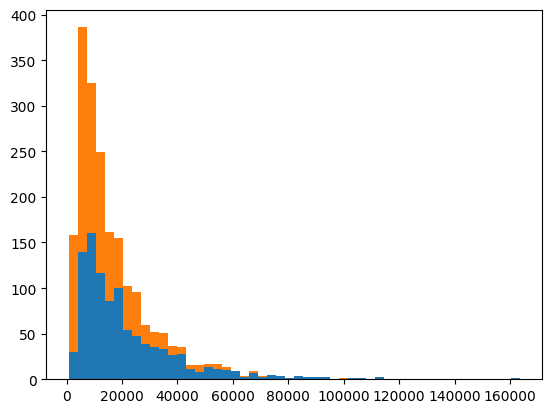

In [38]:
plt.hist([raw_text_n_chars, text_n_chars], 50, stacked= True)
plt.show()

## Shorten texts

In [39]:
corpus = corpus[:1000]
raw_corpus = raw_corpus[:1000]

## TF-IDF

In [40]:
N_TFIDF_FEATURES = 2000
N_GRAM_ANALYZER = 'word' # ‘word’, ‘char’, ‘char_wb’

vectorizer = TfidfVectorizer(max_features = N_TFIDF_FEATURES, analyzer= N_GRAM_ANALYZER, strip_accents = 'unicode')
X = vectorizer.fit_transform(corpus)
print(X.shape)

(1000, 2000)


## Clustering

In [49]:
N_KMEANS_CLUSTERS = 20

kmeans = KMeans(n_clusters = N_KMEANS_CLUSTERS, random_state = 0, n_init = "auto").fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
print(labels[:40])

[ 4  2 18 10 11 10 10  6 10 10 16 15 15 14 18 18  8 15  9 10  2 14 13 18
  4 19  9  9  5 10  9  5 10  3 17  9  2  6 16 15]


In [42]:
for i, (text, label) in enumerate(zip(raw_corpus, labels)):
    if label == 7:
        print(text[:200])
        print(" ")

Typhoon Ellen known in the Philippines as Typhoon Herming was considered the worst typhoon to hit China since 1979. Typhoon Ellen was first noted as a tropical disturbance east of the International Da
 
The muskrat (Ondatra zibethicus), the only species in genus Ondatra and tribe Ondatrini, is a medium-sized semiaquatic rodent native to North America and an introduced species in parts of Europe, Asia
 
The sparsely-spotted stingaree (Urolophus paucimaculatus), also known as the white-spotted stingaree or Dixon's stingaree, is a species of stingray in the family Urolophidae, common off the southern A
 
Hemigrapsus estellinensis is an extinct species of crab, formerly endemic to the Texas Panhandle. It was discovered by Gordon C. Creel in 1962 and was probably already extinct before his description w
 
The brolga (Antigone rubicunda), formerly known as the native companion, is a bird in the crane family. It has also been given the name Australian crane, a term coined in 1865 by well-know

## PCA

In [43]:
N_PCA_COMPONENTS = 2

pca = PCA(n_components = N_PCA_COMPONENTS)
X_pca = pca.fit(X.toarray()).transform(X.toarray())

735.505557476166


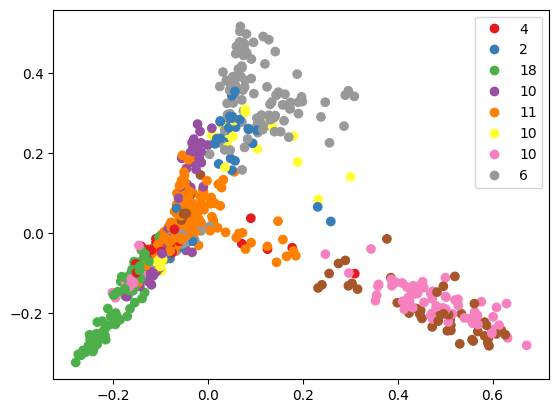

In [44]:
print(kmeans.inertia_) # closer to 0 is better
x, y = X_pca.T
scatter = plt.scatter(x, y, c = labels, cmap="Set1")
plt.legend(handles=scatter.legend_elements()[0], labels=labels.tolist()) # https://stackoverflow.com/a/58516451
plt.show()